In [ ]:
# This code has been adapted from https://github.com/koen-aerts/ECG_ML
%load_ext autoreload
%autoreload 2
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
import sklearn.metrics
import sys, os
sys.path.append('../signal_quality/')


# # read in signal
# record = wfdb.rdrecord(data_path+'100')
# print(record.__dict__)

# # read in annotations
# annotation = wfdb.rdann(data_path+'100', extension='atr')
# annotation.__dict__

In [ ]:
def plot_signal(datfile, SAMPLE_START, SAMPLE_SIZE, CHANNEL):
    record = wfdb.rdrecord(datfile)
    annotation = wfdb.rdann(datfile, 'atr')

    # Get data and annotations for the samples selected below.
    SAMPLE_END = SAMPLE_START + SAMPLE_SIZE
    channel = record.p_signal[SAMPLE_START:SAMPLE_END, CHANNEL]

    # Plot the heart beats. Time scale is number of readings divided by sampling frequency.
    times = (np.arange(SAMPLE_START, SAMPLE_END, dtype='float')) / record.fs
    plt.figure(figsize=(20,10))
    plt.plot(times, channel)

    # Extract annotations.
    where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < SAMPLE_END)
    annotation_symbol = np.array(annotation.symbol)[where]
    annotimes = annotation.sample[where] / record.fs

    # Plot the Annotations 
    plt.scatter(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, c='r')
    for idx in range(len(annotimes)):
        plt.annotate(annotation_symbol[idx], xy = (annotimes[idx], channel.max() * 1.3))

    plt.xlim([SAMPLE_START / record.fs, (SAMPLE_END / record.fs) + 1])
    plt.xlabel('Offset (Seconds from start)')
    plt.ylabel(record.sig_name[CHANNEL])
    plt.grid()
    plt.show()

# data_path = '/zfsauton/project/public/chufang/mit-bih-arrhythmia-database-1.0.0/'
# datfile = data_path+'100'
# SAMPLE_START=114000   # Start of the sample in the file.
# SAMPLE_SIZE=4000      # Number of readings (360 per second).
# CHANNEL=0             # There are 2 channels
# plot_signal(datfile, SAMPLE_START, SAMPLE_SIZE, CHANNEL)

In [ ]:
import datasets
output_dict = datasets.load_mit_bih(data_path='/zfsauton/project/public/chufang/MIT-BIH/', load_method='windows', verbose=False)


In [ ]:
# print(np.stack(output_dict['100']['MLII']['data']).shape)
# print(len(output_dict['100']['MLII']['labels']))
ys = output_dict['100']['MLII']['labels']
np.unique(ys, return_counts=True)


In [ ]:
import sklearn
import sklearn.ensemble
import ecg_featurization

all_x = []
all_y = []

for subject in tqdm(list(output_dict.keys())[:10]):
    for channel in output_dict[subject].keys():
        data = np.array(ecg_featurization.featurize_windows(windows=output_dict[subject][channel]['data'], sampling_rate=125))

        all_x.append(data)
        all_y.append(np.array(output_dict[subject][channel]['labels']))

all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)

In [ ]:
np.unique(all_y, return_counts=True)


In [ ]:
model = sklearn.ensemble.RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_x, all_y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
model.fit(X_train, y_train)

scores = model.predict_proba(X_test)[:,1]
acc = model.score(X_test, y_test)
auc = sklearn.metrics.roc_auc_score(y_test, scores)
print('acc', acc)
print('auc', auc)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, scores, pos_label=1)
plt.plot(fpr, tpr, label='ROC, auc={0:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("Receiver operating characteristic")
plt.legend(loc="lower right"); plt.grid()

In [ ]:
import sqis

all_preds = []
all_y = []

for subject in tqdm(output_dict.keys()):
    for channel in output_dict[subject].keys():
        data = output_dict[subject][channel]['data']
        
        predictions = [
            sqis.sqi_template_matching_correlation(ecg_window=data[i], sampling_rate=125, show=False)
            for i in range(len(data))
            ]
        
        all_preds.append(np.array(predictions))
        all_y.append(np.array(output_dict[subject][channel]['labels']))

all_preds = np.concatenate(all_preds)
all_y = np.concatenate(all_y)



In [ ]:
print('recall', sklearn.metrics.recall_score(y_true=all_y, y_pred=all_preds))
print('precision', sklearn.metrics.precision_score(y_true=all_y, y_pred=all_preds))
print('f1', sklearn.metrics.f1_score(y_true=all_y, y_pred=all_preds))

In [1]:
import importlib
from tqdm import tqdm
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../signal_quality/')
import datasets
import sqis
import ecg_featurization
importlib.reload(datasets)
importlib.reload(sqis)
importlib.reload(ecg_featurization)

x_list = []
y_list = []
data = datasets.load_picc(verbose=False)


998it [00:10, 97.90it/s] 


  0%|          | 0/998 [00:00<?, ?it/s]

0.7056395136159036


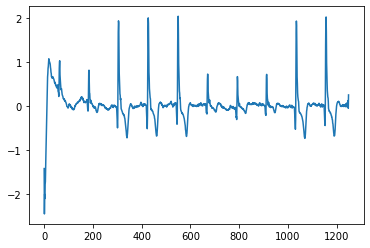

0.7419066040052997


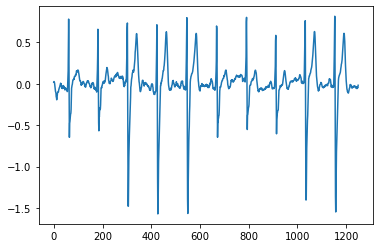

0.7251735564404919


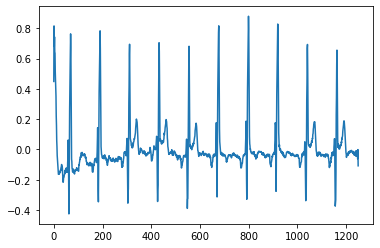

0.6789213546060435


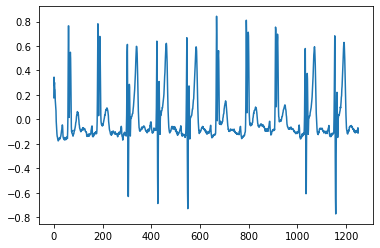

0.6306098955677732


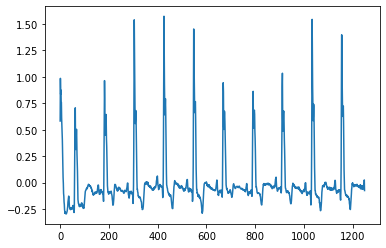

0.6942808005534198


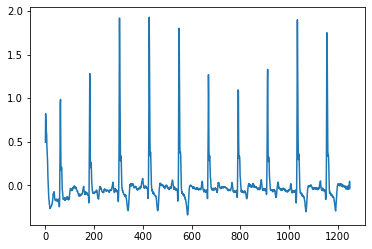

0.7485384335775882


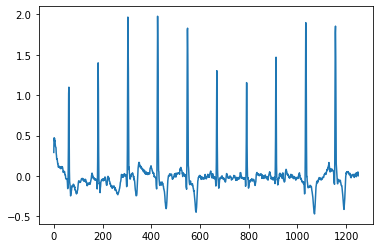

0.757407027241896


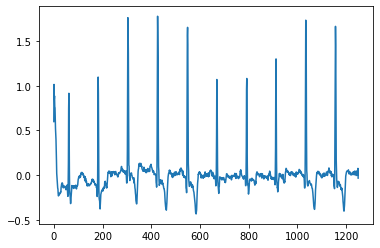

  0%|          | 0/998 [00:00<?, ?it/s]


In [9]:
import biosppy
import antropy
import sklearn

def rsd_sqi(ecg_orig, peaks, sampling_rate):
    """ the relative standard deviation
    """
    
    total = []
    for peak in peaks:
        # Ra is peak to peak amplitude of ECG signal from (R-0.07s, R+0.08s)
        window = ecg_orig[max(int(peak-0.07*sampling_rate), 0) : min(int(peak+0.08*sampling_rate), len(ecg_orig))]    
        # energy of QRS
        sigma_r = np.nanstd(window)

        window = ecg_orig[max(int(peak-0.2*sampling_rate), 0) : min(int(peak+0.2*sampling_rate), len(ecg_orig))]
        sigma_a = np.nanstd(window)
        
        total.append(sigma_r / (sigma_a*2))
    return np.nanmean(total)

def pur_sqi(ecg_orig):
    """" returns the signal purity of the input
    In the case of a periodic signal with a single dominant frequency, 
    it takes the value of one and approaches zero for non-sinusoidal noisy signals.
    antropy.hjorth_params returns 2 floats: mobility, complexity
    Complexity is the value we want
    """
    return antropy.hjorth_params(ecg_orig)[1]

def ent_sqi(ecg_orig):
    """" returns the sample entropy
    """
    return antropy.sample_entropy(ecg_orig)

def pca_sqi(signal):
    # todo: Currently, we are only using single channel (1d) swis
    pca = sklearn.decomposition.PCA(n_components=2)
    pca.fit(signal)

    return np.sum(pca.singular_values_[:5]) / np.sum(pca.singular_values_)

def autocorr_sqi(signal, lag):
    """Calculates the autocorrelation of the specified lag, according to the formula [1]
    [1] https://en.wikipedia.org/wiki/Autocorrelation#Estimation

    source: https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/feature_extraction/feature_calculators.html#autocorrelation
    """
    # This is important: If a series is passed, the product below is calculated
    # based on the index, which corresponds to squaring the series.

    if len(signal) < lag:
        return np.nan
    # Slice the relevant subseries based on the lag
    y1 = signal[: (len(signal) - lag)]
    y2 = signal[lag:]
    # Subtract the mean of the whole series x
    x_mean = np.mean(signal)
    # The result is sometimes referred to as "covariation"
    sum_product = np.sum((y1 - x_mean) * (y2 - x_mean))
    # Return the normalized unbiased covariance
    v = np.var(signal)
    if np.isclose(v, 0):
        return np.nan
    else:
        return sum_product / ((len(signal) - lag) * v)

def zc_sqi(signal):
    """zero cross rate
    """
    return antropy.num_zerocross(signal)

def snr_sqi(signal_raw, signal_cleaned):
    """there are many ways to define SNR, here we use std of filtered vs std of raw
    """
    return np.std(np.abs(signal_cleaned)) / np.std(np.abs(signal_raw))

def perfusion_sqi(pleth_raw, pleth_cleaned):
    """returns perfusion of pleth
    The perfusion index is the ratio of the pulsatile blood flow to the nonpulsatile 
    or static blood in peripheral tissue. In other words, it is the difference of the 
    amount of light absorbed through the pulse of when light is transmitted through 
    the finger AC/DC * 100
    """
    return (np.nanmax(pleth_cleaned) - np.nanmin(pleth_cleaned)) / np.nanmean(pleth_raw) * 100
    

for subject in tqdm(data.keys()):
    for channel in list(data[subject].keys())[4:]:
    ## Remove baseline wader and dc offset with highpass Butterworth.
    #     clean = signal_filter(signal=ecg_signal, sampling_rate=sampling_rate, lowcut=0.5, method="butterworth", order=5)
    ## remove powerline interference
    #     clean = signal_filter(signal=clean, sampling_rate=sampling_rate, method="powerline", powerline=50)

        sampling_rate = 125
        ecg_orig = data[subject][channel]['data']
        ecg_cleaned = nk.ecg_clean(ecg_orig, sampling_rate=sampling_rate, method="neurokit")
        peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=125, method='kalidas2017')[1]['ECG_R_Peaks']

        # print(sqis.bs_sqi(ecg_orig=ecg_orig+np.arange(len(ecg_orig))/len(ecg_orig) * 2, peaks=peaks, sampling_rate=sampling_rate))
        # plt.plot(ecg_orig+np.arange(len(ecg_orig))/len(ecg_orig) * 2); plt.show()

        print(rsd_sqi(ecg_orig, peaks, sampling_rate)) 
        plt.plot(ecg_orig); plt.show()
        
    #     break
    break
